In [1]:
from ursse.utils import normalize, myhist
import ursse.sync_motion_simulation as sms
import numpy as np
from scipy.stats import norm
import pandas as pd
import matplotlib.pyplot as plt
import valstore as vt
import os
from config_ursse import get_from_config
images_dir = os.path.join(get_from_config("URSSE_sync_motion_note_dir"),
                          "images")

In [2]:
rf_noise_std=7e-5
rf_label = "6.0e-05"
model = sms.Model(rf_noise_std=rf_noise_std)
fp = model.simulate(load=rf_label)

working on 1 out of 5
working on 2 out of 5
working on 3 out of 5
working on 4 out of 5
working on 5 out of 5


In [3]:
model.spad_tts = 0.4
model.add_spad_tts_do_fitting_and_binning(verbose=True)
res = {}
features = ['amplitude', 'rms_length', 'slow_phase', 'kick_to_amplitude']
nbins_arr = [40, 40, 20, 40]
for feat, nbins in zip(features, nbins_arr):
    res[feat] = model.get_meas_sim_comparison(feature=feat, nbins=nbins)
res['amp_per_corr'] = model.get_meas_sim_amp_period_corr()

working on file number 1 out of 5
working on file number 2 out of 5
working on file number 3 out of 5
working on file number 4 out of 5
working on file number 5 out of 5


In [4]:
x = res['amplitude']['bin_centers']
y = normalize(res['amplitude']['aggregated_hists']['meas'])/(x[1]-x[0])
sz = np.sqrt(np.average(x**2/2, weights=y))
sz

0.5227469777918049

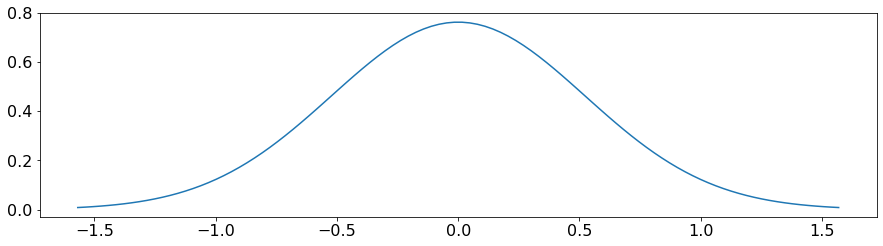

In [5]:
x = np.linspace(-3*sz, 3*sz, 100)
plt.plot(x, norm.pdf(x, 0, sz))

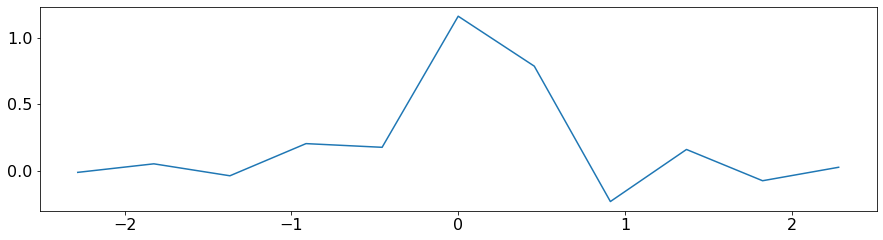

In [6]:
delays_list = [a['meas_df']['delay'].values for a in fp]
delays = np.concatenate(delays_list)
m = 5
rt, bins = np.histogram(delays, bins=2*m+1, density=True)
bin_centers = (bins[1:]+bins[:-1])/2
dz = bins[1]-bins[0]
n = len(bin_centers)
# plt.plot(bin_centers, rt)

pz = normalize(np.diff(norm.cdf(bins, 0, sz)))/dz

t = np.arange(n)
z = np.arange(n)
j = np.arange(n)-m
t2d, z2d = np.meshgrid(t, z, indexing='ij')

aux_tzj = np.repeat((t2d-z2d)[None,:,:], n, axis=0)


j3d = np.repeat(j, n**2, axis=0).reshape(n,n,n)

delta_tzj = (aux_tzj == j3d).astype(int)

Atj = dz*np.einsum('z,tzj', pz, delta_tzj)
q = np.linalg.inv(Atj) @ rt
plt.plot( dz*j, q )

0.6549131465043189

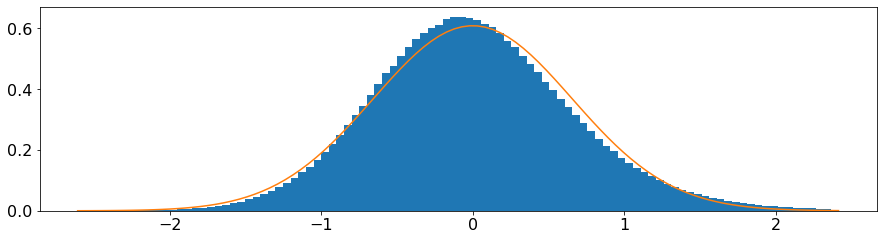

In [7]:
mu = np.mean(delays)
si = np.std(delays)
plt.hist(delays, bins=100, density=True)
xs = np.linspace(min(delays), max(delays), 100)
plt.plot(xs, norm.pdf(xs, mu, si))
si

In [8]:
from scipy.stats import skew
skew(delays)

0.256850196426258

In [9]:
from scipy.stats import skewtest
skewtest(delays)

SkewtestResult(statistic=198.9927879076115, pvalue=0.0)

## Distribution of residuals between the real arrival times and the sinusoidal fits

In [10]:
import scipy.interpolate

In [11]:
idx = 0

In [12]:
df0 = fp[idx]['meas_df']
T0 = 2372
fitper=20
overlapper=3
nper_step=10

def f(t, a0, A, B, T):
    return a0 + A*np.cos(2*np.pi/T*t)+B*np.sin(2*np.pi/T*t)


fitrange = T0*fitper
overlaprange = T0*overlapper
starts = df0.groupby(((df0['revolution'].values)//(fitrange-overlaprange)).astype(int))\
    .apply(lambda v: v.index.values[0]).values
ends = df0.groupby(((df0['revolution'].values-overlaprange)//(fitrange-overlaprange)).astype(int))\
    .apply(lambda v: v.index.values[-1]).values[1:]
nintervals = min(len(starts), len(ends))
starts = starts[:nintervals]
ends = ends[:nintervals]


alist, blist = [],[]
for s,e in zip(starts, ends):
    v = df0.loc[s:e,:]
    x = v['revolution'].values
    y = v['delay'].values
    A = np.vstack([np.cos(2*np.pi/T0*x),np.sin(2*np.pi/T0*x)]).T
    a,b = np.linalg.lstsq(A, y, rcond=None)[0]
    alist.append(a)
    blist.append(b)


fits_df = pd.DataFrame({'start_idx': starts, 'end_idx': ends,
                        'A': alist, 'B': blist})
fits_df_len = len(fits_df.index)
fits_df['start_revolution'] = df0.loc[starts, 'revolution']\
    .reset_index(drop=True)
fits_df['end_revolution'] = df0.loc[ends, 'revolution']\
    .reset_index(drop=True)
fits_df['next_start_revolution'] = fits_df['start_revolution']\
    .shift(-1).values.astype(int)
fits_df['previous_end_revolution'] = fits_df['end_revolution']\
    .shift(1).values.astype(int)
fits_df.loc[fits_df_len-1, 'next_start_revolution'] = \
    fits_df.loc[fits_df_len-1, 'end_revolution']
fits_df.loc[0, 'previous_end_revolution'] = \
    fits_df.loc[0, 'start_revolution']
fits_df['next_A'] = fits_df['A'].shift(-1)
fits_df['next_B'] = fits_df['B'].shift(-1)

def get_one_fit(row):
    revs = np.arange(row['previous_end_revolution'],
                        row['end_revolution'],
                        nper_step)

    def interpAB(val1, val2):
        return np.interp(
            revs,
            [
                row['previous_end_revolution'],
                row['next_start_revolution'],
                row['end_revolution']
            ],
            [val1, val1, val2]
        )
    avals = interpAB(row['A'], row['next_A'])
    bvals = interpAB(row['B'], row['next_B'])
    dels = f(revs, 0, avals, bvals, T0)
    return pd.DataFrame({'revolution': revs.astype(int), 'delay': dels})

res = fits_df.apply(get_one_fit, axis=1)
res = pd.concat(res.to_list(), ignore_index=True, sort=False)

new_revs = np.arange(0, res['revolution'].max(), nper_step)
new_dels = scipy.interpolate.interp1d(res['revolution'], res['delay'],
                        bounds_error=False,
                        fill_value="extrapolate")(new_revs)
res = pd.DataFrame({'revolution': new_revs, 'delay': new_dels})

In [13]:
# resplot = res.loc[:80000, :]
# plt.plot(resplot['revolution'], resplot['delay'])

In [46]:
fit_delays = np.interp(fp[idx]['meas_df']['revolution'], res['revolution'], res['delay'])
residuals = fp[idx]['meas_df']['delay'].values - fit_delays

In [47]:
df0 = pd.DataFrame({'revolution': fp[idx]['meas_df']['revolution'], 'delay': 1e3*fit_delays})

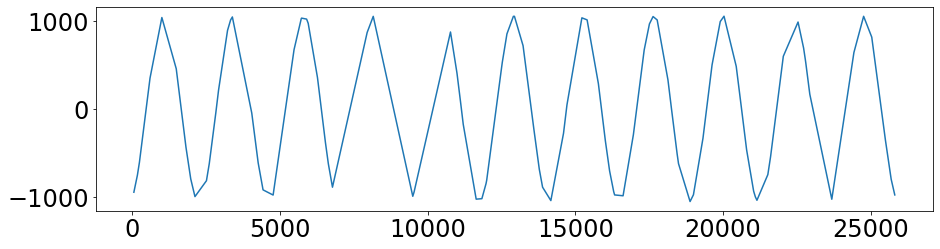

In [48]:
plt.plot(*(lambda x: (x['revolution'], x['delay']) )(df0.loc[:100, :]))

In [49]:
from config_ursse import get_from_config
iota_period_sec = get_from_config("IOTA_revolution_period")
dt_sec = get_from_config("dt")
dt = 0.1
revolutions_per_dt = dt/iota_period_sec
revolutions_per_dt

750000.0

In [50]:
df0['index_of_dt_bin'] = (df0.revolution/revolutions_per_dt).astype(int)
df0['time_sec'] = df0['index_of_dt_bin']*dt

In [51]:
df0

,revolution,delay,index_of_dt_bin,time_sec
0,51,-947.326342,0,0.0
1,171,-752.464504,0,0.0
2,239,-607.019967,0,0.0
3,598,352.807710,0,0.0
4,999,1043.092009,0,0.0
...,...,...,...,...
1480021,450123392,308.534887,600,60.0
1480022,450123677,-539.943829,600,60.0
1480023,450123880,-988.361734,600,60.0
1480024,450123931,-1060.549796,600,60.0


In [61]:
nbins=30
gate = (-2500, 2500)
y_max = df0.groupby('index_of_dt_bin').delay.apply(lambda x: max(np.histogram(np.asarray(x), bins=nbins, range=gate)[0])).max()

In [62]:
bins = np.histogram([], bins=nbins, range=gate)[1]
bin_centers = (bins[1:]+bins[:-1])/2

In [63]:
hists =\
(df0.groupby('index_of_dt_bin').delay.apply(lambda x: np.histogram(np.asarray(x), bins=nbins, range=gate)[0])).to_list()

In [64]:
n_revolutions = df0['revolution'].max()+300
n_dt_bins = int(n_revolutions/revolutions_per_dt)

In [65]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML, Image
# equivalent to rcParams['animation.html'] = 'html5'
rc('animation', html='html5')
y_max = np.concatenate(hists)[:nbins*n_dt_bins].max()

In [66]:
gate_ns = (gate[0]/1000, gate[1]/1000)

In [67]:
plt.rcParams.update({'font.size': 24,'legend.fontsize':24})

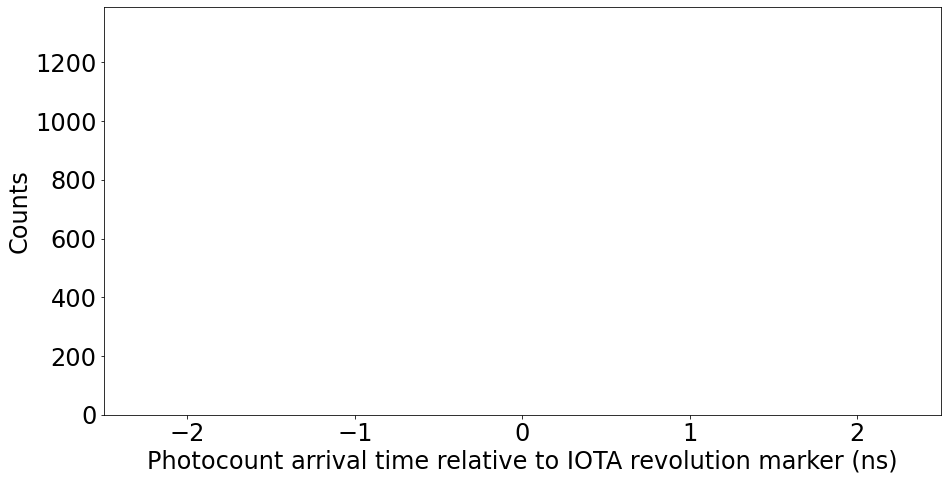

In [68]:
fig, ax = plt.subplots(figsize=(15,7.5))

ax.set_xlim(gate_ns)
ax.set_ylim((0, 1.1*y_max))
ax.set_xlabel('Photocount arrival time relative to IOTA revolution marker (ns)')
ax.set_ylabel('Counts')
line, = ax.plot([], [], lw=2, color='blue')

In [69]:
# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return (line,)

In [70]:
from scipy import interpolate

In [71]:
# animation function. This is called sequentially
def animate(i):
    x0 = bin_centers/1000
    y0 = hists[i]
    x = np.linspace(min(x0), max(x0), 100)
    f = interpolate.interp1d(x0, y0, kind='cubic')
    y = f(x)
    line.set_data(x, y)
    ax.collections.clear()
    ax.fill_between(x, 0, y, facecolor='blue')
    return (line,)

In [76]:
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=n_dt_bins, interval=int(dt*1000), blit=True)

In [73]:
anim

In [82]:
anim.save('animation.mpeg', writer='ffmpeg', fps=10)